# Challenge 3 - Identify a signal in colored Gaussian noise amongst other (simulated) signals
Amélie Orban, 14/02/22.  

Use the data file "challenge3.gwf". The channel name is "H1:CHALLENGE3".
These are real LIGO data from O2, though the time labels have been adjusted and some simulated signals have been added. The data is colored, Gaussian noise containing a loud simulated signal with m1 = m2 = 10 solar masses (1 solar mass = 1.989 x 10^30 kilograms). [Link to the data file.](https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf)



## Install and import statements
As usual, the first step is to install and import the necessary librairies and packages. 

In [ ]:
# Installing the necessary packages
# For GW data analysis
! pip install -q 'gwosc==0.5.4' 
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'
! pip install -q 'gwpy==2.0.2'
# For plotting
%matplotlib inline

In [ ]:
# Importing the packages in the code
import numpy
import pylab
import pycbc
from pycbc.waveform import get_td_waveform
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
import gwpy
from gwpy.timeseries import TimeSeries

## Downloading and plotting the data
Before analysing the data, it must of course be downloaded and stored into a data object to make it accessible in the code. This is done by reading the file and assigning the informations to the data object which will be used to analyse the data. 

We also print some of the characteristics of this data, such as the sampling rate, the time values, and the duration, and we plot it in order to get an idea of what the looks like.

In [ ]:
# Download the data (change name! ->  challenge 3)
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

# Create a strain object using GWPY and PYCBC (change names! ->  challenge 3)
  # The PYCBC object will be used for computing the SNR of the data
gwpy_strain = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')
# Can print the content of the strain object to see the info it contains
print("This is the strain object created with the Challenge 3 data: \n", gwpy_strain)

--2022-02-13 20:01:45--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  29.0MB/s    in 9.7s    

2022-02-13 20:01:55 (25.1 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]

This is the strain object created with the Challenge 3 data: 
 TimeSeries([-3.04517369e-19, -3.35465069e-19, -3.35210566e-19,
            ...,  4.46471052e-19,  5.07624678e-19,
             4.98623016e-19]
           unit: ct,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE3,
           channel: H1:CHALLENGE3)


In [ ]:
# Retrieve and print the sampling rate (rate of samples per second [Hz]) and duration of the data

sample_rate = 1.0/gwpy_strain.dt # dt = time between successive samples [s]
print("\n The sampling rate of the data is: ", sample_rate)

print("\n Checking the time values of this data: ", gwpy_strain.times)
len_times = len(gwpy_strain.times)
duration = gwpy_strain.times[len_times-1] - gwpy_strain.times[0]
print("\n The duration of the data is: ", duration)


 The sampling rate of the data is:  4096.0 1 / s

 Checking the time values of this data:  [0.00000000e+00 2.44140625e-04 4.88281250e-04 ... 4.09599927e+03
 4.09599951e+03 4.09599976e+03] s

 The duration of the data is:  4095.999755859375 s


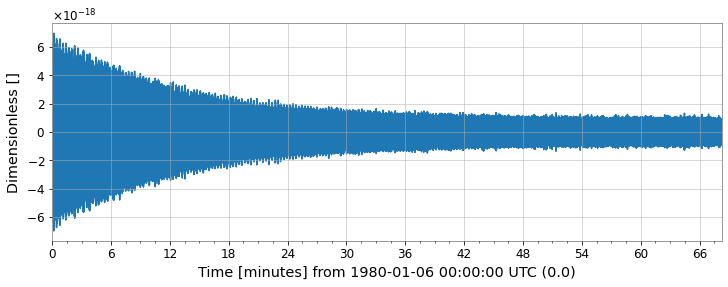

In [ ]:
# Plot the strain object containing the data
plot = gwpy_strain.plot()
ax = plot.gca()
ax.set_ylabel("Dimensionless []")
plot.show(warn=False)

## Question 1: Time of merger (computing the SNR)
*What is the merger time of this signal?*

In order to determine the time of merger of the signal we are looking for in this data, we can compute the SNR time series of the data to precisely locate the signal we are interested in, using a template that correspond to what we know of said signal, i.e. with m1 = m2 = 10 solar masses. Note: in this case it would be harder to use the method of the Q-transform to determine where the merger is (approximately) because it is said that "some simulated signals" have been added to the data, meaning that we would see numerous signals and not only the one we are intersted in.

The process is very similar to what was done in Question 4 of the previous challenge: the data has to be preconditioned, the PSD of the data is computed, the template of the signal is created and prepared, and then these three elements are combined to compute the SNR. 

In [ ]:
# Preconditioning the data

# Remove the low frequency content and downsample the data to 2048Hz
pycbc_strain = highpass(pycbc_strain, 20.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

# Remove the begining and ending (small portions) from the data
  # Avoid filters that act on times which are not causally connected (ensure they do not wrap around the input)
conditioned_strain = pycbc_strain.crop(2, 2)

In [ ]:
# Computing the PSD and creating the 1/PSD filter

# Compute the PSD (with pycbc_strain here)
  # Use 4 second samples (Welch method)
psd = conditioned_strain.psd(4)

# Interpolate the PSD to match the data
psd = interpolate(psd, conditioned_strain.delta_f)

# Limit the filter length of 1/PSD
  # 1/PSD will act as a filter with an effective length of 4 seconds
  # Don't include frequencies below 15 Hz, as data has been highpassed above 15 Hz
psd = inverse_spectrum_truncation(psd, int(4 * conditioned_strain.sample_rate),
                                  low_frequency_cutoff=20)

# => Now, can directly use this PSD to filter the data in a controlled manner

Text(0, 0.5, 'Normalized amplitude')

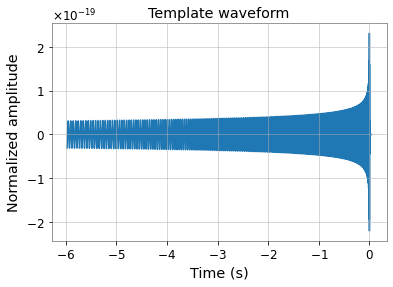

In [ ]:
# Generate a time-domain template waveform using approximate "SEOBNRv4_opt" with parameters: m1=m2=10 solar masses
  # Only the 'plus' polarization of the created waveform is kept (because it only differs from the 'cross' polarization by some phase constant)
sample_rate = 2048 # samples per second
hp, _ = get_td_waveform(approximant='SEOBNRv4_opt',
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=20)

# Plot this waveform
pylab.figure()
pylab.title("Template waveform")
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

Text(0, 0.5, 'Strain')

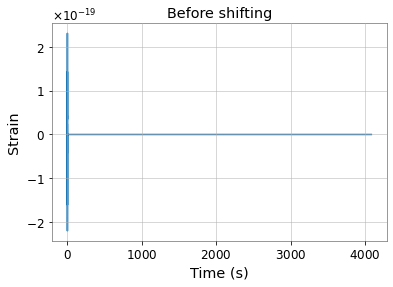

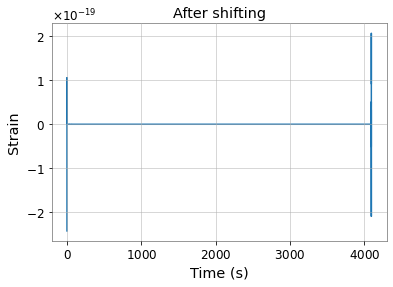

In [ ]:
# Preparing the signal template

# Resize the vector to match our data
hp.resize(len(conditioned_strain))

# Shift the template so that the beginning of the signal corresponds to the time of merger
  # If we want the SNR time series to correspond to the approximate merger location: 
  # must shift data so that the merger is at begining of the data
  # cyclic_time_shift: shifts the timeseries by a given amount of time (acts as if data if on a ring)
  # Merger is now at time zero (but start of signal is in the negatives), so we can use the start time to shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)

# Plot the signal before and after shifting for visualization
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

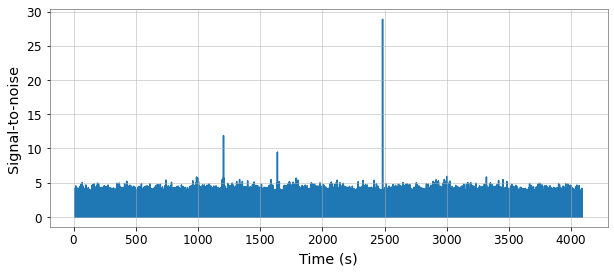

We found a signal at 2483.96728515625s with SNR 28.875814057421216


In [ ]:
# Calculating the Signal-to-Noise time series

snr = matched_filter(template, 
                     conditioned_strain,
                     psd=psd, 
                     low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax() # find the peak (its location in the array)
snrp = snr[peak] # get its SNR value
time = snr.sample_times[peak] # get its location (in time)

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In this case, the SNR plot shows three separate peaks, which seem to represent three distinct signals (which are distinct from the noise). Two of those signals must be the "added signals" that were put in the data, and one of them has to be the original BH merger signal that we were looking for: the one with m1 = m2 = 10 solar masses and the one for which the template was created. Because the template was created specifically for this signal, it follows that the highest correspondance, i.e. the highest SNR value, corresponds to said signal. Thus, the merger time of the signal we were looking for is 2483.96728515625 s.

## Question 2: Matched-filter SNR of the signal
*What is the matched-filter SNR of this signal?*

This can be determined by computing the SNR time series of the data, which is what was just done in the previous question in order to determine the time of merger of the signal. It was determined to be located at 2483.96728515625 s, and it has an SNR value of 28.875814057421216. This shows that this signal is indeed a GW signal as we assume a threshold on matched filter SNR of 8 to claim detection of GW.